## Import Libaraies

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as pl
import numpy as np
import warnings
import os
warnings.filterwarnings("ignore")

# Define Functions

In [2]:
target = 'DollarsPerMegawattHour'
boolean_dict = {'Y':1, 'N':0}
island_dict = {'NI':1, 'SI':0}

def read_energy_csv(filename, PoC = None):
  df = pd.read_csv(filename)
  if PoC != None:
    df = df[df['PointOfConnection'] == PoC]
    df = df.drop(columns = ['PointOfConnection'])
  df['DateTime'] = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.000%z") for date in df['PublishDateTime']]
  df['IsProxyPriceFlag'] = [boolean_dict[c] for c in df['IsProxyPriceFlag']]
  # df = df.drop(columns = ['Island']) #'TradingDate',
  df['Date'] = [p.date() for p in df['DateTime']]
  df['Time'] = [p.time() for p in df['DateTime']]
  df['IntTime'] = [t.hour*3600+t.minute*60+t.second for t in df['Time']]
  df['Year'] = [d.year for d in df['Date']]
  df['Month'] = [d.month for d in df['Date']]
  df['Day'] = [d.day for d in df['Date']]
  df = df.drop(columns = ['Island'])
  return df

def num_string(x, length = 2):
  string = str(x)
  while len(string) < length:
    string = "0"+string
  return string

def date_string(day, month, year, length = 2):
  return (num_string(year,length)+
          num_string(month,length)+
          num_string(day,length))

def make_url(day, month, year = 2023):
  year_string = date_string(day, month, year)
  s = "https://www.emi.ea.govt.nz/Wholesale/Datasets/DispatchAndPricing/DispatchEnergyPrices/"
  s = s+str(year)+"/"+year_string+"_DispatchEnergyPrices.csv"
  return s

seconds_in_a_day = 86400
def cyclic_encoder(x, min = 0, max = seconds_in_a_day):
  lambd = [2*np.pi*(n-min)/(max-min) for n in x]
  sin_x = [np.sin(n) for n in lambd]
  cos_x = [np.cos(n) for n in lambd]
  return (sin_x, cos_x)

def csv_to_arff(csv_file_path, arff_file_path, relation_name='relation'):

    df = pd.read_csv(csv_file_path)

    # Open the ARFF file for writing
    with open(arff_file_path, 'w') as f:
        # Write the relation name
        f.write(f"@relation {relation_name}\n\n")

        # Write attribute names and types
        for col in df.columns:
            if df[col].dtype == 'object':
                f.write(f"@attribute {col} nominal\n")
            elif df[col].dtype == 'int64':
                f.write(f"@attribute {col} numeric\n")
            elif df[col].dtype == 'float64':
                f.write(f"@attribute {col} numeric\n")
            else:
                f.write(f"@attribute {col} unknown\n")

        f.write("\n@data\n")

        # Write the data
        for index, row in df.iterrows():
            f.write(','.join(map(str, row.values)) + '\n')

def make_targets_with_delay(dict, delay: int = 1, target='Avg$PerMWHr'):
    not_target = 'Med$PerMWHr' if target == 'Avg$PerMWHr' else 'Avg$PerMWHr'
    target_col = dict['Avg$PerMWHr']
    previous_tar_str = 'Prev'+target
    previous_not_tar_str = 'Prev'+not_target
    targets = dict[target]
    previous_col = list(dict[previous_tar_str])
    previous_other_col = list(dict[previous_not_tar_str])
    for i in range(delay -1):
        previous_col.insert(0,0)
        previous_col.pop()
        previous_other_col.insert(0,0)
        previous_other_col.pop()
    df = dict.drop(columns=target)
    df = dict.drop(columns=not_target)
    df[target] = targets
    df[previous_tar_str] = previous_col
    df[previous_not_tar_str] = previous_other_col

    # re-order the columns to put the target at the end
    column_to_move = target
    cols = [col for col in df.columns if col != column_to_move]
    re_ordered = cols + [column_to_move]
    df = df[re_ordered]

    df = df.iloc[delay - 1:]

    return df

# Specify Date Range

In [3]:
month_date_dict = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
                   7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

# first available date
dates = [(1, 11, 2022)]

# specify the last day
last_day = (29, 11, 2024)

while dates[-1] != last_day:
  last_date = dates[-1]
  date = (last_date[0]+1, last_date[1], last_date[2])
  if date[0] > month_date_dict[date[1]]:
    date = (1, date[1]+1, date[2])
  if date[1] > 12:
    date = (1, 1, date[2]+1)
  dates.append(date)

# Specify Point of Connection

### Available Options
* 'ABY0111' 'ALB0331' 'ALB1101' 'APS0111' 'ARA2201' 'ARG1101' 'ARI1101'
'ARI1102' 'ASB0661' 'ASY0111' 'ATI2201' 'AVI2201' 'BAL0331' 'BDE0111'
'BEN2201' 'BEN2202' 'BLN0331' 'BOB1101' 'BPD1101' 'BPE0331' 'BPE0551'
'BPE2201' 'BPT1101' 'BRB0331' 'BRK0331' 'BRY0661' 'BWK1101' 'CBG0111'
'CLH0111' 'CML0331' 'COL0111' 'COL0661' 'CPK0111' 'CPK0331' 'CST0331'
'CUL0331' 'CUL0661' 'CYD0331' 'CYD2201' 'DOB0331' 'DOB0661' 'DVK0111'
'EDG0331' 'EDN0331' 'FHL0331' 'FKN0331' 'GFD0331' 'GLN0331' 'GLN0332'
'GOR0331' 'GYM0661' 'GYT0331' 'HAM0111' 'HAM0331' 'HAM0551' 'HAM2201'
'HAY0111' 'HAY0331' 'HAY1101' 'HAY2201' 'HEN0331' 'HEN2201' 'HEP0331'
'HIN0331' 'HKK0661' 'HLY0331' 'HLY2201' 'HOB1101' 'HOR0331' 'HOR0661'
'HRP2201' 'HTI0331' 'HTI1101' 'HUI0331' 'HWA0331' 'HWA0332' 'HWA1101'
'HWA1102' 'HWB0331' 'HWB1101' 'HWB2201' 'INV0331' 'INV2201' 'INV2202'
'ISL0331' 'ISL0661' 'ISL2201' 'JRD1101' 'KAI0111' 'KAW0111' 'KAW0112'
'KAW1101' 'KAW2201' 'KBY0661' 'KBY0662' 'KIK0111' 'KIK2201' 'KIN0111'
'KIN0112' 'KIN0113' 'KIN0331' 'KMO0331' 'KOE1101' 'KPA1101' 'KPO1101'
'KPU0661' 'KUM0661' 'KWA0111' 'LFD1101' 'LFD1102' 'LTN0331' 'LTN2201'
'MAN2201' 'MAT1101' 'MCH0111' 'MDN1101' 'MDN2201' 'MGM0331' 'MHO0331'
'MKE1101' 'MLG0111' 'MLG0331' 'MNG0331' 'MNG1101' 'MNI0111' 'MPE1101'
'MST0331' 'MTI2201' 'MTM0331' 'MTN0331' 'MTO0331' 'MTR0331' 'NAP2201'
'NAP2202' 'NMA0331' 'NPK0331' 'NSY0331' 'NWD0661' 'OAM0331' 'OHA2201'
'OHB2201' 'OHC2201' 'OHK2201' 'OKI2201' 'OKN0111' 'ONG0331' 'OPK0331'
'ORO1101' 'ORO1102' 'OTA0221' 'OTA2201' 'OTI0111' 'OWH0111' 'PAK0331'
'PAO1101' 'PEN0221' 'PEN0251' 'PEN0331' 'PEN1101' 'PNI0331' 'PPI2201'
'PRM0331' 'RDF0331' 'RDF2201' 'RFN1101' 'RFN1102' 'ROS0221' 'ROS1101'
'ROT0111' 'ROT0331' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201' 'SBK0661'
'SDN0331' 'SFD0331' 'SFD2201' 'STK0331' 'STK0661' 'STK2201' 'STU0111'
'SVL0331' 'SWN0251' 'SWN2201' 'TAB2201' 'TAK0331' 'TGA0111' 'TGA0331'
'THI2201' 'TIM0111' 'TKA0111' 'TKA0331' 'TKB2201' 'TKR0331' 'TKU0331'
'TKU2201' 'TMI0331' 'TMK0331' 'TMN0551' 'TMU0111' 'TMU1101' 'TNG0111'
'TNG0551' 'TRK0111' 'TRK2201' 'TUI1101' 'TWC2201' 'TWH0331' 'TWI2201'
'TWZ0331' 'UHT0331' 'WAI0111' 'WAI0501' 'WDV0111' 'WDV1101' 'WEL0331'
'WGN0331' 'WHI0111' 'WHI2201' 'WHU0331' 'WIL0331' 'WIR0331' 'WKM2201'
'WKO0331' 'WPA2201' 'WPR0331' 'WPR0661' 'WPW0331' 'WRD0331' 'WRK0331'
'WRK2201' 'WTK0111' 'WTK0331' 'WTK2201' 'WTU0331' 'WVY0111' 'WVY1101'
'WWD1102' 'WWD1103'

In [4]:
pocs   = ['ALB0331', 'HAM0331']
dfs = {poc: [] for poc in pocs}  # Dictionary to hold dataframes for each PoC

for poc in pocs:
    for day, month, year in dates:
        url = make_url(day, month, year)
        try:
            df = read_energy_csv(url, PoC=poc)
            dfs[poc].append(df)
        except Exception as e:
            print(f"Failed to process {url} for PoC {poc}: {e}")

# Save Full Data for Further Use

In [17]:
# Process data
full_data_dict = {}

for poc in pocs:
    dfs_transformed = []
    for df in dfs[poc]:
        df_t = df.copy()
        # Group data and compute necessary columns
        avg = df_t.groupby(["TradingPeriod"]).mean(numeric_only=True)['DollarsPerMegawattHour']
        df_t = df_t.groupby(["TradingPeriod"]).median(numeric_only=True)
        df_t['Avg$PerMWHr'] = avg
        dfs_transformed.append(df_t)

    full_data = pd.concat(dfs_transformed)
    full_data.columns = full_data.columns.str.replace('DollarsPerMegawattHour', 'Med$PerMWHr')

    # Add previous period columns for averages and medians
    avgs = [a for a in full_data['Avg$PerMWHr']]
    meds = [m for m in full_data['Med$PerMWHr']]
    avgs.insert(0, avgs[0])
    avgs.pop()
    meds.insert(0, meds[0])
    meds.pop()
    full_data['PrevAvg$PerMWHr'] = avgs
    full_data['PrevMed$PerMWHr'] = meds

    # Calculate the difference between current and previous average prices
    full_data['PriceDifference'] = full_data['Avg$PerMWHr'] - full_data['PrevAvg$PerMWHr']

    # Add cyclic encoding for period and date
    full_data['SinPeriod'], full_data['CosPeriod'] = cyclic_encoder(full_data.index, max=48)

    # Compute cyclic encoding for dates
    date_col = []
    for day, month, period in zip(full_data['Day'], full_data['Month'], full_data.index):
        value = day + (period - 1) / 48
        for m in range(1, int(month)):
            value += month_date_dict[m]
        date_col.append(value)
    full_data['SinDate'], full_data['CosDate'] = cyclic_encoder(date_col, max=365)

    # Round all columns to 8 decimal places
    for column in full_data.columns:
        full_data[column] = [round(d, 8) for d in full_data[column]]

    # Ensure the directory exists before saving
    filename = f"all_{poc}_data.csv"
    if not os.path.exists('./full_data'):
        os.makedirs('./full_data')

    # Save the full data to CSV
    full_data.to_csv(f'./full_data/{filename}')

    # Store the processed data in the dictionary
    full_data_dict[poc] = full_data

## **Exploring our dataset:**

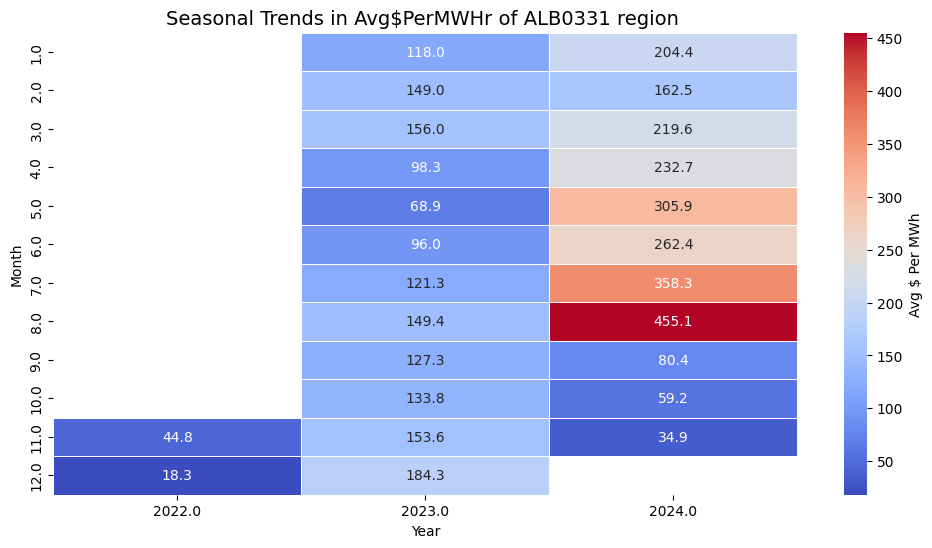

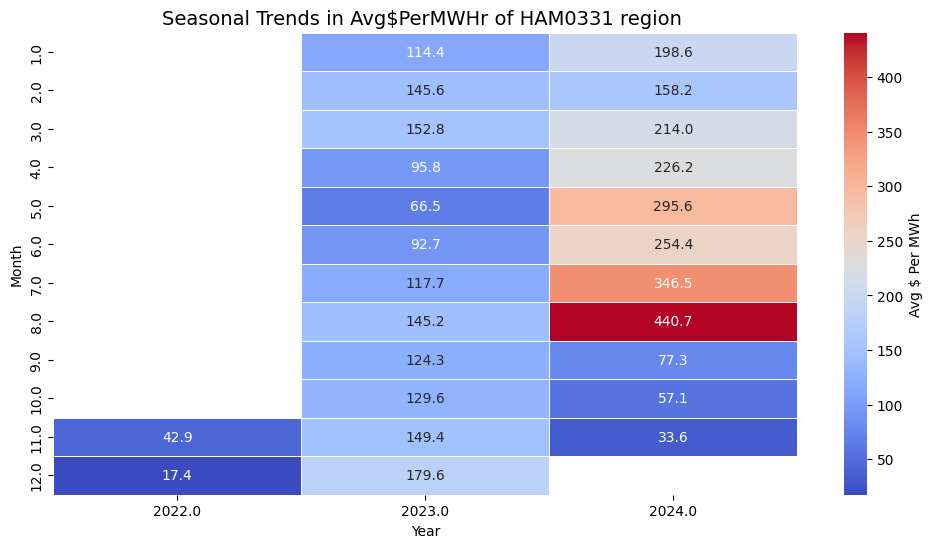

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns  # Ensure seaborn is imported

# Group and calculate monthly average energy prices for each year.
alb_grouped = full_data_dict['ALB0331'].groupby(['Year', 'Month'])['Avg$PerMWHr'].mean().unstack()
ham_grouped = full_data_dict['HAM0331'].groupby(['Year', 'Month'])['Avg$PerMWHr'].mean().unstack()


# Transpose the grouped data for plotting ,this means months as rows and years as columns
alb_grouped_transposed = alb_grouped.T
ham_grouped_transposed = ham_grouped.T

# Create a heatmap of ALB0331
plt.figure(figsize=(12, 6))
sns.heatmap(
    alb_grouped_transposed,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'Avg $ Per MWh'},
)

# Add labels and title
plt.title("Seasonal Trends in Avg$PerMWHr of ALB0331 region ", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Month")
plt.show()

# Create a heatmap of HAM0331
plt.figure(figsize=(12, 6))
sns.heatmap(
    ham_grouped_transposed,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'Avg $ Per MWh'},
)

# Add labels and title
plt.title("Seasonal Trends in Avg$PerMWHr of HAM0331 region ", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Month")
plt.show()

The heatmap provides a clear visualization of the average price of electricity per MWh (Avg$PerMWHr) across the months of the year for the years 2022, 2023, and 2024. we can observe that the average price per MWh is rising year after year

In [19]:
# print columns of the ALB0331 DataFrame
print("Columns in ALB0331 DataFrame:")
print(full_data_dict['ALB0331'].columns)

# print columns of the HAM0331 DataFrame
print("\nColumns in HAM0331 DataFrame:")
print(full_data_dict['HAM0331'].columns)


Columns in ALB0331 DataFrame:
Index(['IsProxyPriceFlag', 'Med$PerMWHr', 'IntTime', 'Year', 'Month', 'Day',
       'Avg$PerMWHr', 'PrevAvg$PerMWHr', 'PrevMed$PerMWHr', 'PriceDifference',
       'SinPeriod', 'CosPeriod', 'SinDate', 'CosDate'],
      dtype='object')

Columns in HAM0331 DataFrame:
Index(['IsProxyPriceFlag', 'Med$PerMWHr', 'IntTime', 'Year', 'Month', 'Day',
       'Avg$PerMWHr', 'PrevAvg$PerMWHr', 'PrevMed$PerMWHr', 'PriceDifference',
       'SinPeriod', 'CosPeriod', 'SinDate', 'CosDate'],
      dtype='object')


# Make Datasets from the Full Data

### Specify the Target
* Options: 'Avg\\$PerMWHr' or 'Med\\$PerMWHr'

In [20]:
target = ['Avg$PerMWHr', 'Med$PerMWHr']

### Specify the Delay (each unit is 30 mins)

In [21]:
delay = [1,  ## 30 mins delay
         8,  ## 4 hrs delay
         12,  ## 6 hrs delay
         48,  ## 24 hrs delay
        ]

### Generate Datasets (CSV and ARFF)

In [22]:
if not os.path.exists('./datasets'):
    os.makedirs('./datasets')
arff_option = True
for poc in pocs:
    for t in target:
        for d in delay:
            if not os.path.exists(f'./datasets/{poc}'):
                os.makedirs(f'./datasets/{poc}')
            delay_in_hour = f"{(d/2):.0f}" if (d/2).is_integer() else f"{(d/2):.1f}"
            df = make_targets_with_delay(full_data_dict[poc], delay=d, target=t)
            df.to_csv(
                f'./datasets/{poc}/{poc}_{t[:3].lower()}_{delay_in_hour}hr.csv', index=False
            )
            if arff_option:
                csv_to_arff(
                    f'./datasets/{poc}/{poc}_{t[:3].lower()}_{delay_in_hour}hr.csv',
                    f'./datasets/{poc}/{poc}_{t[:3].lower()}_{delay_in_hour}hr.arff',
                    relation_name=f'relation: PoC: {poc}; Target: {t}; Delay: {delay_in_hour}hr'
                )


# **Combine the dataset of the 2 regions**

In [23]:

from scipy.io import arff
import pandas as pd

# Load ARFF file
ham_data, meta = arff.loadarff('/content/datasets/HAM0331/HAM0331_avg_0.5hr.arff')

# Convert ham_data to DataFrame
ham_data = pd.DataFrame(ham_data)


alb_data, meta = arff.loadarff('/content/datasets/ALB0331/ALB0331_avg_0.5hr.arff')

# Convert alb_data to DataFrame
alb_data = pd.DataFrame(alb_data)


# In order to differentiate the data sources, we added PoC column
ham_data['PoC'] = 'HAM0331'
alb_data['PoC'] = 'ALB0331'

combined_data = pd.concat([ham_data, alb_data], ignore_index=True)

# Drop columns
columns_to_drop = [
    "IsProxyPriceFlag",
    "PrevMed$PerMWHr",
    "SinPeriod", "CosPeriod"
]
combined_data = combined_data.drop(columns=columns_to_drop)

# Removing rows with missing 'PriceDifference'
combined_data['PriceDifference']=combined_data[['PriceDifference']].dropna()
combined_data.head()

# Save the combined dataset to a new CSV file
combined_file_path = './full_data/combined_data.csv'
combined_data.to_csv(combined_file_path, index=False)

print(f"Combined data saved to {combined_file_path}")

Combined data saved to ./full_data/combined_data.csv


In [24]:
combined_data.head(10)

,IntTime,Year,Month,Day,PrevAvg$PerMWHr,PriceDifference,SinDate,CosDate,Avg$PerMWHr,PoC
0,889.0,2022.0,11.0,1.0,26.045714,0.000000,-0.858764,0.512371,26.045714,HAM0331
1,2386.0,2022.0,11.0,1.0,26.045714,-7.522857,-0.858580,0.512679,18.522857,HAM0331
2,4337.5,2022.0,11.0,1.0,18.522857,-8.179524,-0.858396,0.512987,10.343333,HAM0331
3,6138.0,2022.0,11.0,1.0,10.343333,-1.053333,-0.858212,0.513295,9.290000,HAM0331
4,7792.0,2022.0,11.0,1.0,9.290000,-6.111429,-0.858028,0.513603,3.178571,HAM0331
5,9729.5,2022.0,11.0,1.0,3.178571,-2.238571,-0.857844,0.513910,0.940000,HAM0331
6,11390.0,2022.0,11.0,1.0,0.940000,-0.910000,-0.857659,0.514218,0.030000,HAM0331
7,13340.0,2022.0,11.0,1.0,0.030000,0.000000,-0.857475,0.514526,0.030000,HAM0331
8,15124.0,2022.0,11.0,1.0,0.030000,0.000000,-0.857290,0.514833,0.030000,HAM0331
9,16937.5,2022.0,11.0,1.0,0.030000,0.451667,-0.857106,0.515141,0.481667,HAM0331


In [25]:
combined_data.tail(10)

,IntTime,Year,Month,Day,PrevAvg$PerMWHr,PriceDifference,SinDate,CosDate,Avg$PerMWHr,PoC
72730,69133.5,2024.0,11.0,29.0,56.562857,-40.242857,-0.511755,0.859131,16.320000,ALB0331
72731,70789.0,2024.0,11.0,29.0,16.320000,-9.792000,-0.511447,0.859315,6.528000,ALB0331
72732,72730.0,2024.0,11.0,29.0,6.528000,3.205333,-0.511139,0.859498,9.733333,ALB0331
72733,74528.5,2024.0,11.0,29.0,9.733333,45.593333,-0.510831,0.859681,55.326667,ALB0331
72734,76192.0,2024.0,11.0,29.0,55.326667,5.656190,-0.510522,0.859864,60.982857,ALB0331
72735,77991.0,2024.0,11.0,29.0,60.982857,11.110000,-0.510214,0.860048,72.092857,ALB0331
72736,79945.5,2024.0,11.0,29.0,72.092857,-54.176190,-0.509905,0.860230,17.916667,ALB0331
72737,81744.0,2024.0,11.0,29.0,17.916667,-0.683333,-0.509597,0.860413,17.233333,ALB0331
72738,83384.0,2024.0,11.0,29.0,17.233333,-10.996190,-0.509288,0.860596,6.237143,ALB0331
72739,85189.0,2024.0,11.0,29.0,6.237143,64.214286,-0.508980,0.860779,70.451429,ALB0331


# **K-means Clustering**

# **River code**

In [26]:
!pip install river

# **Correlation**

PriceDifference    1.000000
Avg$PerMWHr        0.256571
SinDate            0.000153
CosDate            0.000076
Year               0.000044
Month             -0.000264
Day               -0.000542
IntTime           -0.021552
PrevAvg$PerMWHr   -0.256591
Name: PriceDifference, dtype: float64


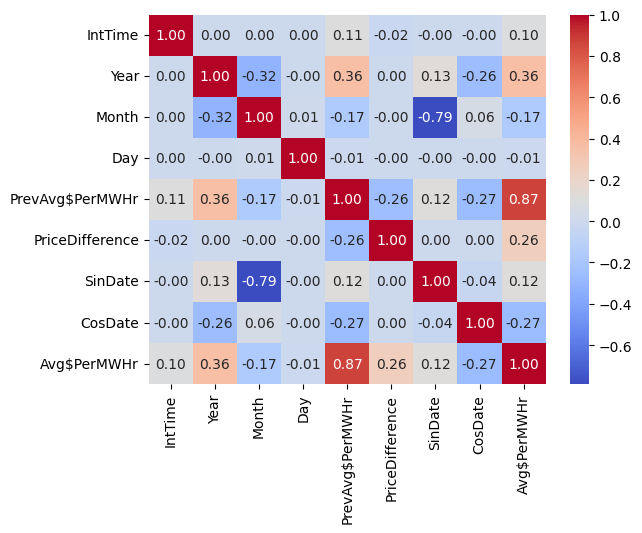

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove POC COLUMN
data = combined_data.drop(columns=['PoC'])

# Calculate correlation matrix
correlation_matrix = data.corr()

# Focus on correlations with 'PriceDifference'
corr_pricediff = correlation_matrix['PriceDifference']

# Print correlations
print(corr_pricediff.sort_values(ascending=False))

# Plot heatmap for visualization
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


# **The K-means**

In [28]:
# Import libraries
import pandas as pd
from river.preprocessing import StandardScaler
from river import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define relevant features for clustering
relevant_features = ['PriceDifference', 'CosDate', 'SinDate']

# Normalize the data using River's StandardScaler
scaler = StandardScaler()

# Apply normalization row-by-row
for column in relevant_features:
    for i, value in enumerate(data[column]):
        scaler.learn_one({column: value})
        normalized_value = scaler.transform_one({column: value})[column]
        data.at[i, column] = normalized_value

# Drop rows with NaN values in the relevant features
data = data.dropna(subset=relevant_features)

# Reduce dimensionality using PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data[relevant_features])

# Function to evaluate KMeans clustering
def evaluate_kmeans_clustering(n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    stream_data = (dict(zip(relevant_features, row)) for row in reduced_data)
    cluster_ass = []

    # Apply clustering on streaming data
    for row in stream_data:
        kmeans.learn_one(row)
        pred = kmeans.predict_one(row)
        cluster_ass.append(pred)

    # Evaluate clustering
    cluster_labels = np.array(cluster_ass)
    sil_score = silhouette_score(reduced_data, cluster_labels)
    db_score = davies_bouldin_score(reduced_data, cluster_labels)
    return sil_score, db_score, kmeans, cluster_ass

# Test multiple cluster configurations
cluster_configuration = [2, 3]
best_sil_score = -1
best_kmeans_model = None
best_cluster_ass = None

for n_clusters in cluster_configuration:
    sil_score, db_score, kmeans_model, cluster_ass = evaluate_kmeans_clustering(n_clusters)
    print(f"n_clusters={n_clusters}, Silhouette Score={sil_score}, Davies-Bouldin Score={db_score}")

    if sil_score > best_sil_score:
        best_config = n_clusters
        best_sil_score = sil_score
        best_kmeans_model = kmeans_model
        best_db_score = db_score
        best_cluster_ass = cluster_ass

print(f"\nThe Best configuration is : n_clusters={best_config}")
print(f"The Best Silhouette Score is : {best_sil_score}")
print(f"The Best Davies-Bouldin Score is: {best_db_score}")

# Assign clusters to the original dataset
data['Cluster'] = best_cluster_ass

n_clusters=2, Silhouette Score=0.7036927154139435, Davies-Bouldin Score=1.4076947964392048
n_clusters=3, Silhouette Score=0.01560844780739701, Davies-Bouldin Score=5.898020231740371

The Best configuration is : n_clusters=2
The Best Silhouette Score is : 0.7036927154139435
The Best Davies-Bouldin Score is: 1.4076947964392048


In [30]:
from collections import defaultdict

# Dictionary to store sum of points and count for each cluster
sums = defaultdict(lambda: defaultdict(float))
counts = defaultdict(int)

# Iterate through the data to assign clusters and aggregate
stream_data = (dict(zip(relevant_features, row)) for row in reduced_data)

for row in stream_data:
    cluster = best_kmeans_model.predict_one(row)
    counts[cluster] += 1
    for feature, value in row.items():
        sums[cluster][feature] += value

# Compute the centroids
centroids = {
    cluster: {feature: total / counts[cluster]
              for feature, total in features.items()}
    for cluster, features in sums.items()
}

# Print centroids
print("\nCluster Centroids:")
for cluster_id, centroid in centroids.items():
    print(f"\nCluster {cluster_id} centroid:")
    for feature, value in centroid.items():
        print(f"{feature}: {value}")



Cluster Centroids:

Cluster 0 centroid:
PriceDifference: 0.0005375802391358568
CosDate: -0.00021492847991942516
SinDate: -0.013032153712776206

Cluster 1 centroid:
PriceDifference: -1.1495679078424144
CosDate: 0.4596055900305569
SinDate: 27.86811081885628


In [29]:
# Add date-related features for seasonal analysis
data['NumericalDate'] = data['Year'] * 365 + data['Month'] * 30 + data['Day']

In [31]:
data.head()

,IntTime,Year,Month,Day,PrevAvg$PerMWHr,PriceDifference,SinDate,CosDate,Avg$PerMWHr,Cluster,NumericalDate
0,889.0,2022.0,11.0,1.0,26.045714,0.000000,0.000000,0.000000,26.045714,1,738361.0
1,2386.0,2022.0,11.0,1.0,26.045714,-1.000000,1.000000,1.000000,18.522857,1,738361.0
2,4337.5,2022.0,11.0,1.0,18.522857,-0.793740,1.224867,1.224698,10.343333,1,738361.0
3,6138.0,2022.0,11.0,1.0,10.343333,0.850109,1.341894,1.341539,9.290000,1,738361.0
4,7792.0,2022.0,11.0,1.0,9.290000,-0.454022,1.414636,1.414062,3.178571,1,738361.0


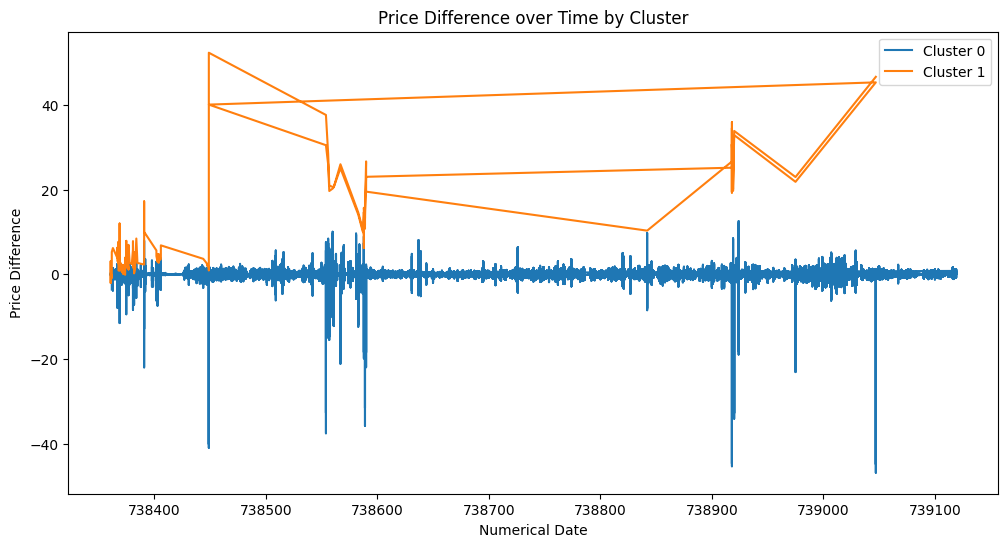

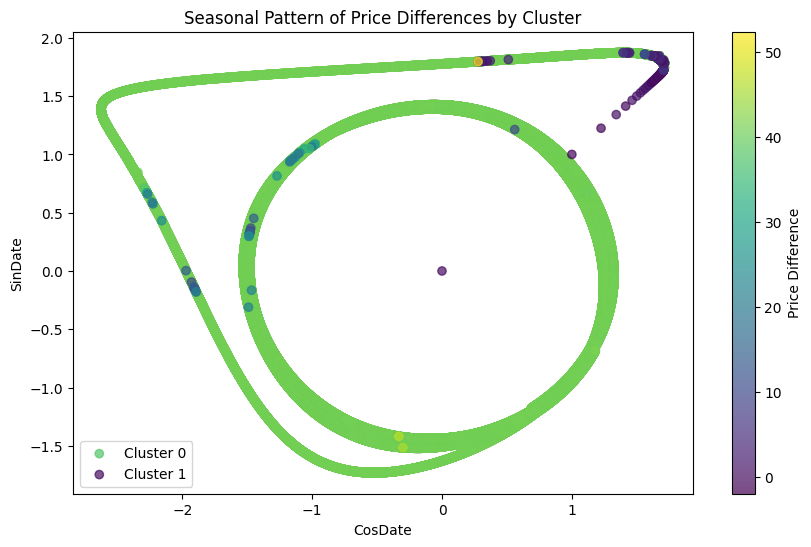

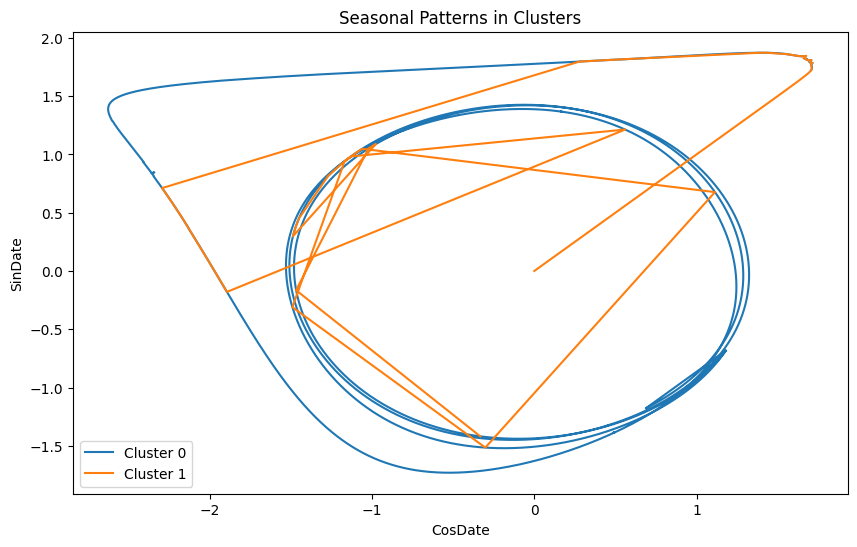

In [33]:
# Plotting PriceDifference over time for each cluster
plt.figure(figsize=(12, 6))
for clusterId in range(best_config):
    clusterData = data[data['Cluster'] == clusterId]
    plt.plot(clusterData['NumericalDate'], clusterData['PriceDifference'], label=f'Cluster {clusterId}')

plt.xlabel('Numerical Date')
plt.ylabel('Price Difference')
plt.title('Price Difference over Time by Cluster')
plt.legend()
plt.show()

# Plot the relationship between CosDate, SinDate, and PriceDifference by Cluster
plt.figure(figsize=(10, 6))
for clusterId in range(best_config):
    clusterData = data[data['Cluster'] == clusterId]
    plt.scatter(clusterData['CosDate'], clusterData['SinDate'],
                c=clusterData['PriceDifference'], cmap='viridis', label=f'Cluster {clusterId}', alpha=0.7)

plt.colorbar(label='Price Difference')
plt.xlabel('CosDate')
plt.ylabel('SinDate')
plt.title('Seasonal Pattern of Price Differences by Cluster')
plt.legend()
plt.show()

#visualize the relationship between CosDate and SinDate for a deeper insight into seasonality
plt.figure(figsize=(10, 6))
for clusterId in range(best_config):
    clusterData = data[data['Cluster'] == clusterId]
    plt.plot(clusterData['CosDate'], clusterData['SinDate'], label=f'Cluster {clusterId}')

plt.xlabel('CosDate')
plt.ylabel('SinDate')
plt.title('Seasonal Patterns in Clusters')
plt.legend()
plt.show()





In [34]:
# Group data by clusters and calculate average price differences by month
year_month_cluster= (
    data.groupby(['Year', 'Month', 'Cluster'])['PriceDifference']
    .mean()
    .reset_index()
)
print(year_month_cluster)


# Pivot the data for heatmap creation
year_month_cluster['Year-Month'] = (
    year_month_cluster['Year'].astype(str) + '-' +
    year_month_cluster['Month'].astype(str).str.zfill(2)
)


heatmap_data = year_month_cluster.pivot(
    index='Year-Month', columns='Cluster', values='PriceDifference'
)


      Year  Month  Cluster  PriceDifference
0   2022.0   11.0        0        -0.087370
1   2022.0   11.0        1         1.430462
2   2022.0   12.0        0        -0.020509
3   2022.0   12.0        1         5.694550
4   2023.0    1.0        0        -0.030728
5   2023.0    1.0        1         9.441296
6   2023.0    2.0        0         0.000666
7   2023.0    3.0        0        -0.001170
8   2023.0    4.0        0        -0.000210
9   2023.0    5.0        0        -0.099201
10  2023.0    5.0        1        24.711965
11  2023.0    6.0        0        -0.099702
12  2023.0    6.0        1        14.673801
13  2023.0    7.0        0         0.000041
14  2023.0    8.0        0         0.000090
15  2023.0    9.0        0         0.000052
16  2023.0   10.0        0        -0.000077
17  2023.0   11.0        0         0.000081
18  2023.0   12.0        0        -0.001608
19  2024.0    1.0        0         0.001127
20  2024.0    2.0        0        -0.003454
21  2024.0    2.0        1      

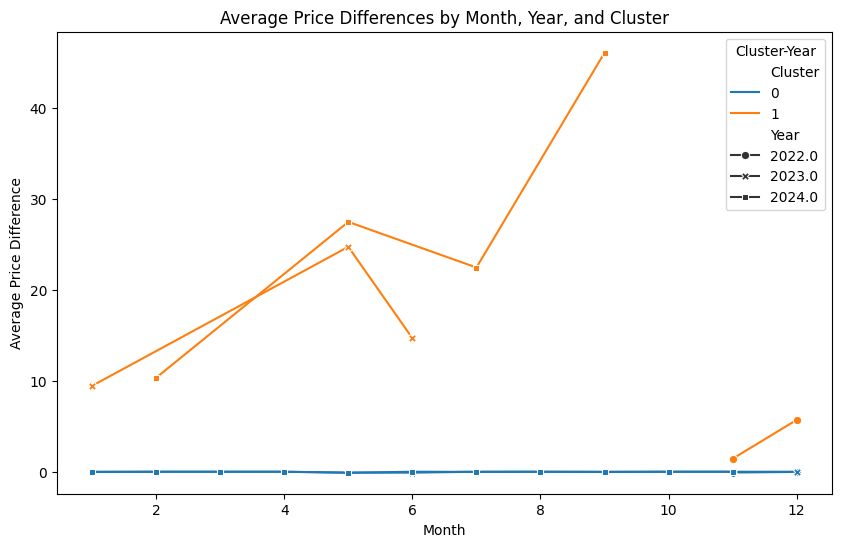

In [38]:
plot = data.groupby(['Year', 'Month', 'Cluster'])['PriceDifference'].mean().reset_index()
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=plot,
    x='Month',
    y='PriceDifference',
    hue='Cluster',
    style='Year',  #plot
    markers=True,
    dashes=False
)
plt.title('Average Price Differences by Month, Year, and Cluster')
plt.xlabel('Month')
plt.ylabel('Average Price Difference')
plt.legend(title='Cluster-Year')
plt.show()

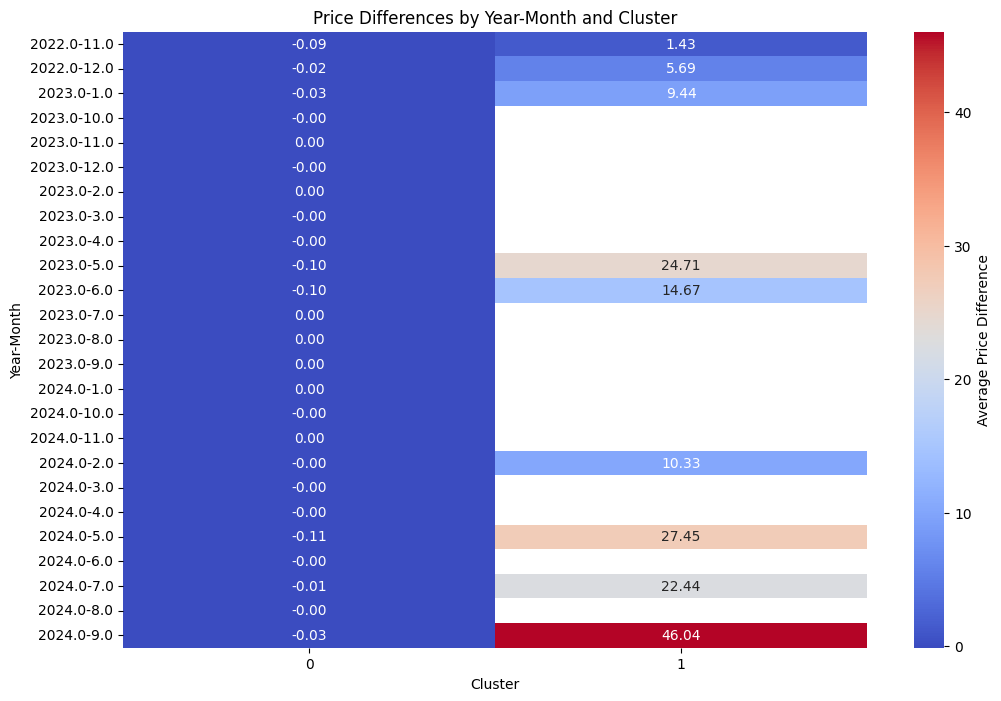

In [40]:
# Create Heatmap for Year-Month and Cluster
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar_kws={'label': 'Average Price Difference'}
)
plt.title('Price Differences by Year-Month and Cluster')
plt.ylabel('Year-Month')
plt.xlabel('Cluster')
plt.show()


In [41]:
# datetime column using Year, Month, and Day
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Check if the date is a weekend
data['IsWeekend'] = data['Date'].dt.weekday >= 5

# Display the DataFrame
print(data)

# Display new features
print(data.head())

       IntTime    Year  Month   Day  PrevAvg$PerMWHr  PriceDifference  \
0        889.0  2022.0   11.0   1.0        26.045714         0.000000   
1       2386.0  2022.0   11.0   1.0        26.045714        -1.000000   
2       4337.5  2022.0   11.0   1.0        18.522857        -0.793740   
3       6138.0  2022.0   11.0   1.0        10.343333         0.850109   
4       7792.0  2022.0   11.0   1.0         9.290000        -0.454022   
...        ...     ...    ...   ...              ...              ...   
72735  77991.0  2024.0   11.0  29.0        60.982857         0.139626   
72736  79945.5  2024.0   11.0  29.0        72.092857        -0.680947   
72737  81744.0  2024.0   11.0  29.0        17.916667        -0.008595   
72738  83384.0  2024.0   11.0  29.0        17.233333        -0.138217   
72739  85189.0  2024.0   11.0  29.0         6.237143         0.807109   

        SinDate   CosDate  Avg$PerMWHr  Cluster  NumericalDate       Date  \
0      0.000000  0.000000    26.045714        

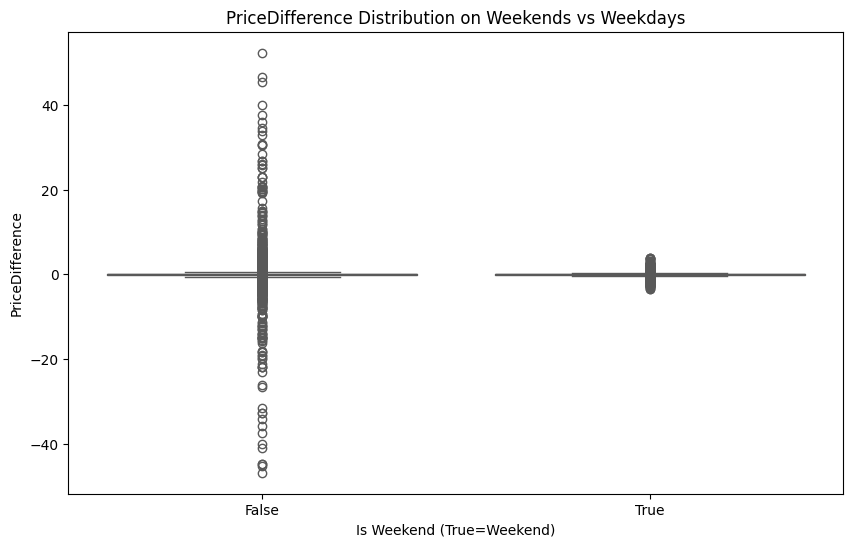

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='IsWeekend', y='PriceDifference', palette='Set2')
plt.title("PriceDifference Distribution on Weekends vs Weekdays")
plt.xlabel("Is Weekend (True=Weekend)")
plt.ylabel("PriceDifference")
plt.show()


In [44]:
from scipy.stats import ttest_ind

# Separate weekdays and weekends
weekdays = data[data['IsWeekend'] == False]['PriceDifference']
weekends = data[data['IsWeekend'] == True]['PriceDifference']

# t-test
t_stat, p_value = ttest_ind(weekdays, weekends, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference in price differences between weekdays and weekends is statistically significant.")
else:
    print("The difference in price differences between weekdays and weekends is not statistically significant.")


T-statistic: 1.0174659097079488, P-value: 0.3089353711520826
The difference in price differences between weekdays and weekends is not statistically significant.


# **Regression**

In [45]:
data.head()

,IntTime,Year,Month,Day,PrevAvg$PerMWHr,PriceDifference,SinDate,CosDate,Avg$PerMWHr,Cluster,NumericalDate,Date,IsWeekend
0,889.0,2022.0,11.0,1.0,26.045714,0.000000,0.000000,0.000000,26.045714,1,738361.0,2022-11-01,False
1,2386.0,2022.0,11.0,1.0,26.045714,-1.000000,1.000000,1.000000,18.522857,1,738361.0,2022-11-01,False
2,4337.5,2022.0,11.0,1.0,18.522857,-0.793740,1.224867,1.224698,10.343333,1,738361.0,2022-11-01,False
3,6138.0,2022.0,11.0,1.0,10.343333,0.850109,1.341894,1.341539,9.290000,1,738361.0,2022-11-01,False
4,7792.0,2022.0,11.0,1.0,9.290000,-0.454022,1.414636,1.414062,3.178571,1,738361.0,2022-11-01,False


In [48]:
import pandas as pd

# Round values to a reasonable precision
data['Rounded_Avg$PerMWHr'] = data['Avg$PerMWHr'].round(2)

# Count the frequency of each unique value
val_counts = data['Rounded_Avg$PerMWHr'].value_counts()

# Display the most frequent unique values
top_values = val_counts.head(10)
print("Most frequent average price values:")
print(top_values)

Most frequent average price values:
Rounded_Avg$PerMWHr
0.01    1218
0.02     887
0.03     661
0.04     268
0.11      69
0.12      63
0.05      61
0.10      59
0.07      53
0.52      49
Name: count, dtype: int64


In [51]:
import pandas as pd

# Display the first 10 rows of the 'Avg$PerMWHr' column
first_val = data['Avg$PerMWHr'].head(10)

# Print the first 10 values
print(first_val)


0    26.045714
1    18.522857
2    10.343333
3     9.290000
4     3.178571
5     0.940000
6     0.030000
7     0.030000
8     0.030000
9     0.481667
Name: Avg$PerMWHr, dtype: float64


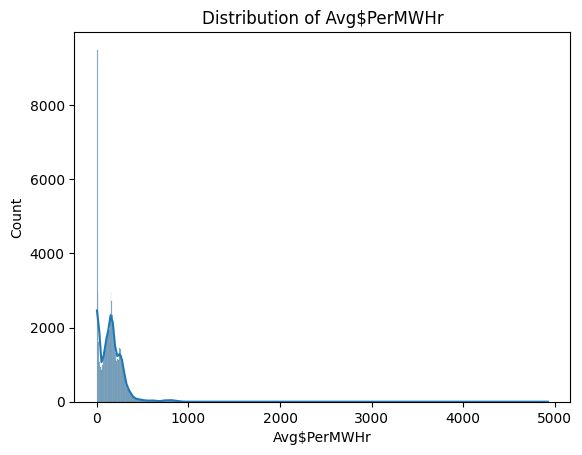

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram
sns.histplot(data['Avg$PerMWHr'], kde=True)
plt.title('Distribution of Avg$PerMWHr')
plt.show()



In [53]:
import pandas as pd
from river import metrics, preprocessing, ensemble
import numpy as np
from river import forest


# Preprocess the Data
# Drop rows with NaN in critical columns
data = data.dropna(subset=['PrevAvg$PerMWHr', 'Avg$PerMWHr'])

# Add interaction terms for cyclical features
data['PriceDiff_SinDate'] = data['PriceDifference'] * data['SinDate']
data['PriceDiff_CosDate'] = data['PriceDifference'] * data['CosDate']

# Normalize the features using River's StandardScaler
# the PriceDifference, CosDate and SinDate are already normalized in clustering
scaler = preprocessing.StandardScaler()
for column in ['PriceDiff_SinDate', 'PriceDiff_CosDate', 'PrevAvg$PerMWHr']:
    for i, value in enumerate(data[column]):
        scaler.learn_one({column: value})
        normalized_value = scaler.transform_one({column: value})[column]
        data.at[i, column] = normalized_value

# Initialize an AMFRegressor
regressor = forest.AMFRegressor(seed=42)

# Initialize the metric for evaluation
metric = metrics.MAE()

# Incrementally update the model
for i, row in data.iterrows():
    features = {
        'PriceDifference': row['PriceDifference'],
        'SinDate': row['SinDate'],
        'CosDate': row['CosDate'],
        'PrevAvg$PerMWHr': row['PrevAvg$PerMWHr'],
        'PriceDiff_SinDate': row['PriceDiff_SinDate'],
        'PriceDiff_CosDate': row['PriceDiff_CosDate'],
    }

    # Learn from the current row
    regressor.learn_one(features, row['Avg$PerMWHr'])

    # Predict the target variable
    y_predection = regressor.predict_one(features)

    # Update the evaluation metric
    metric.update(row['Avg$PerMWHr'], y_predection)

# Output model performance
print(f"Final MAE: {metric.get()}")

Final MAE: 0.030333104676201095


In [58]:
from river import forest, metrics
from river.drift import ADWIN
import numpy as np

# Initialize the model
regressor = forest.AMFRegressor(seed=42)
# Initialize the metric
metric = metrics.MAE()
# Initialize the drift detector "ADWIN"
drift_detector = ADWIN()

drift_count = 0


# updating the target variable over time
for i, row in data.iterrows():
    features = {
        'PriceDifference': row['PriceDifference'],
        'SinDate': row['SinDate'],
        'CosDate': row['CosDate'],
        'PrevAvg$PerMWHr': row['PrevAvg$PerMWHr'],
        'PriceDiff_SinDate': row['PriceDiff_SinDate'],
        'PriceDiff_CosDate': row['PriceDiff_CosDate'],
    }

    # Update the drift detector with the target value
    drift_detector.update(row['Avg$PerMWHr'])

    # Check if a concept drift is detected
    if drift_detector.drift_detected:
        print(f"Concept drift detected at index {i}")
        drift_count += 1  # Increment the drift counter

        # Reset the model and reinitialize the drift detector
        regressor = forest.AMFRegressor(seed=42)
        drift_detector = ADWIN()

    # Learn from the current row
    regressor.learn_one(features, row['Avg$PerMWHr'])

    # Predict the target variable
    y_pred_drift = regressor.predict_one(features)

    # Update the evaluation metric
    metric.update(row['Avg$PerMWHr'], y_pred_drift)

# Output model performance
print(f"Final MAE: {metric.get()}")
print(f"Total number of concept drifts detected: {drift_count}")

Concept drift detected at index 319
Concept drift detected at index 607
Concept drift detected at index 671
Concept drift detected at index 831
Concept drift detected at index 895
Concept drift detected at index 991
Concept drift detected at index 1215
Concept drift detected at index 1279
Concept drift detected at index 1471
Concept drift detected at index 1631
Concept drift detected at index 1791
Concept drift detected at index 1855
Concept drift detected at index 1919
Concept drift detected at index 1983
Concept drift detected at index 2015
Concept drift detected at index 2239
Concept drift detected at index 2431
Concept drift detected at index 2623
Concept drift detected at index 2783
Concept drift detected at index 2943
Concept drift detected at index 3039
Concept drift detected at index 3103
Concept drift detected at index 3199
Concept drift detected at index 3263
Concept drift detected at index 3359
Concept drift detected at index 3487
Concept drift detected at index 3519
Concept